# Homework 2

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-04-08

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the corporate and government bonds symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`, containing EOD price data as of 2024-12-13.

------------------------------------------------------------------------------------------
# Problem 1: Constructing fixed rate bonds

In [30]:
import QuantLib as ql
import pandas as pd
import datetime as dt

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

## a. Prepare the symbology and market data files for fixed rate government and corporate bonds

Load the `bond_symbology`, `bond_market_prices_eod` and `govt_on_the_run` Excel files into dataframes. 

Filter the symbology frame for fixed rate bonds only (cpn_type="FIXED").


In [31]:
# Set as-of-date
as_of_date = pd.to_datetime('2024-12-13')

# Load bond_symbology.xlsx
bond_symbology  = pd.read_excel('./data/bond_symbology.xlsx')
bond_symbology  = bond_symbology[bond_symbology['cpn_type'] == 'FIXED']

# Add term and TTM columns
bond_symbology['term'] = round((bond_symbology['maturity'] - bond_symbology['start_date']).dt.days / 365.25, 2)
bond_symbology['TTM'] = round((bond_symbology['maturity'] - as_of_date).dt.days / 365.25, 2)
display(bond_symbology.head())


# Load bond_market_prices_eod
bond_market_prices_eod = pd.read_excel('./data/bond_market_prices_eod.xlsx')

# Add mid prices and yields
bond_market_prices_eod['midPrice'] = 0.5*(bond_market_prices_eod['bidPrice'] + bond_market_prices_eod['askPrice'])
bond_market_prices_eod['midYield'] = 0.5*(bond_market_prices_eod['bidYield'] + bond_market_prices_eod['askYield'])
display(bond_market_prices_eod.head())

# Load govt_on_the_run, as of 2024-12-13
govt_on_the_run = pd.read_excel('./data/govt_on_the_run.xlsx')

# Keep OTR treasuries only
govt_on_the_run_simple = govt_on_the_run[~govt_on_the_run['ticker'].str.contains('B|C')]
display(govt_on_the_run_simple.head())


,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.0,18.39
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.0,19.39
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.0,20.16
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2015-05-13,2045-05-13,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.0,20.41
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2016-02-23,2026-02-23,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV,10.0,1.20


,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132,93.5185,5.1560
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194,63.9775,5.2180
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205,63.9655,5.2290
3,2024-12-13,Corp,AAPL,US037833EF38,BBG00Z3VQ626,63.262,63.766,0.9420,5.249,5.200,63.5140,5.2245
4,2024-12-13,Corp,AAPL,US037833CD08,BBG00DHQX9M5,82.278,82.848,1.4120,5.227,5.177,82.5630,5.2020


,ticker,date,figi,isin
0,GT10 Govt,2024-12-13,BBG01QKHSMP5,US91282CLW90
3,GT2 Govt,2024-12-13,BBG01QZFYJV6,US91282CLY56
4,GT20 Govt,2024-12-13,BBG01QVTC1Y0,US912810UF39
9,GT3 Govt,2024-12-13,BBG01R4Z7Y32,US91282CMB45
10,GT30 Govt,2024-12-13,BBG01QKHSL31,US912810UE63


## c. Add a function to construct generic fixed rate bond objects from symbology data

Implement the  create_schedule_from_symbology() function below. 

Identify and display the `AAPL 2.2 09/11/29` bond details in the symbology dataframe. Use create_schedule_from_symbology() to generate and display the cashflow schedule for `AAPL 2.2 09/11/29`.


In [32]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [33]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first =  get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

In [34]:
# Use one row of the symbology dataframe as input to the create_schedule_from_symbology() function.
corp_bond_details = bond_symbology[bond_symbology['security'] == 'AAPL 2.2 09/11/29'].iloc[0]
print("Corp bond details for:", corp_bond_details['security'])
display(corp_bond_details)

# Create cashflow_schedule
cashflow_schedule = create_schedule_from_symbology(corp_bond_details)
print("Cashflow dates for:", corp_bond_details['security'])

# List cashflow dates
list(cashflow_schedule)


Corp bond details for: AAPL 2.2 09/11/29


ticker                           AAPL
class                            Corp
figi                     BBG00Q5L6G53
isin                     US037833DP29
und_bench_isin           US91282CMA61
security            AAPL 2.2 09/11/29
name                        APPLE INC
type                           GLOBAL
coupon                            2.2
cpn_type                        FIXED
dcc                            30/360
cpn_freq                            2
days_settle                         1
start_date        2019-09-11 00:00:00
cpn_first         2020-03-11 00:00:00
acc_first         2019-09-11 00:00:00
maturity          2029-09-11 00:00:00
mty_typ                      CALLABLE
rank                     Sr Unsecured
amt_out                        1750.0
country                            US
currency                          USD
status                           ACTV
term                             10.0
TTM                              4.74
Name: 18, dtype: object

Cashflow dates for: AAPL 2.2 09/11/29


[Date(11,9,2019),
 Date(11,3,2020),
 Date(11,9,2020),
 Date(11,3,2021),
 Date(11,9,2021),
 Date(11,3,2022),
 Date(11,9,2022),
 Date(11,3,2023),
 Date(11,9,2023),
 Date(11,3,2024),
 Date(11,9,2024),
 Date(11,3,2025),
 Date(11,9,2025),
 Date(11,3,2026),
 Date(11,9,2026),
 Date(11,3,2027),
 Date(11,9,2027),
 Date(11,3,2028),
 Date(11,9,2028),
 Date(11,3,2029),
 Date(11,9,2029)]

## c. Add function to construct generic fixed rate bond objects from symbology data

Use one row of the symbology dataframe as input to the function. Use create_schedule_from_symbology() internally to create the cashflow schedule.

In [35]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
    
    if details['class'] == 'Corp':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['class'] == 'Govt':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported asset class, {type(details['class'])}, {details['class']}")

    
    # Create issue_date from details['start_date']
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create coupon from details['coupon']
    coupon = float(details['coupon'])/100.


    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


In [36]:
# Use one row of the symbology dataframe as input to the function.
corp_bond_object = create_bond_from_symbology(corp_bond_details)

print("Corp bond object details for", corp_bond_details['security'])
print('Start date:', corp_bond_object.startDate())
print('Maturity date:', corp_bond_object.maturityDate())
print('Bond face notional:', corp_bond_object.notional())


Corp bond object details for AAPL 2.2 09/11/29
Start date: September 11th, 2019
Maturity date: September 11th, 2029
Bond face notional: 100.0


## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Create the bond objects and display the future cashflows for following securities:

* the `T 5 3/8 02/15/31` government bond and 
* the `AAPL 2.2 09/11/29` corporate bond.

In [37]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    day_counter = bond.dayCounter()    
    
    x = [(cf.date(), day_counter.yearFraction(calc_date, cf.date()), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_yearFrac, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowYearFrac': cf_yearFrac, 'CashFlowAmount': cf_amount})

    # filter for payment dates > calc_date
    cashflows_df = cashflows_df[cashflows_df.CashFlowYearFrac > 0]
    return cashflows_df


In [38]:
# Pick one government and one corporate bond from symbology, create the bond objects.
govt_bond_details = bond_symbology[bond_symbology['security'] == 'T 5 3/8 02/15/31'].iloc[0]
print("Govt bond details for", govt_bond_details['security'])
display(govt_bond_details)

# Create govt_bond_object
govt_bond_object = create_bond_from_symbology(govt_bond_details)

Govt bond details for T 5 3/8 02/15/31


ticker                              T
class                            Govt
figi                     BBG000FZB1J0
isin                     US912810FP85
und_bench_isin           US91282CMA61
security             T 5 3/8 02/15/31
name                  US TREASURY N/B
type                    US GOVERNMENT
coupon                          5.375
cpn_type                        FIXED
dcc                           ACT/ACT
cpn_freq                            2
days_settle                         1
start_date        2001-02-15 00:00:00
cpn_first         2001-08-15 00:00:00
acc_first         2001-02-15 00:00:00
maturity          2031-02-15 00:00:00
mty_typ                        NORMAL
rank                        Unsecured
amt_out                       16428.0
country                            US
currency                          USD
status                           ACTV
term                             30.0
TTM                              6.17
Name: 150, dtype: object

In [39]:
# Govt bond: display the future cashflows.
print("Govt bond future cashflows for:", govt_bond_details['security'])
govt_bond_cf = get_bond_cashflows(govt_bond_object, calc_date=calc_date)
display(govt_bond_cf)

# Corp bond: display the future cashflows.
print("Corp bond future cashflows for:", corp_bond_details['security'])
corp_bond_cf = get_bond_cashflows(corp_bond_object, calc_date=calc_date)
display(corp_bond_cf)

Govt bond future cashflows for: T 5 3/8 02/15/31


,CashFlowDate,CashFlowYearFrac,CashFlowAmount
47,"February 15th, 2025",0.166667,2.6875
48,"August 15th, 2025",0.666667,2.6875
49,"February 15th, 2026",1.166667,2.6875
50,"August 15th, 2026",1.666667,2.6875
51,"February 15th, 2027",2.166667,2.6875
52,"August 15th, 2027",2.666667,2.6875
53,"February 15th, 2028",3.166667,2.6875
54,"August 15th, 2028",3.666667,2.6875
55,"February 15th, 2029",4.166667,2.6875
56,"August 15th, 2029",4.666667,2.6875


Corp bond future cashflows for: AAPL 2.2 09/11/29


,CashFlowDate,CashFlowYearFrac,CashFlowAmount
10,"March 11th, 2025",0.244444,1.1
11,"September 11th, 2025",0.744444,1.1
12,"March 11th, 2026",1.244444,1.1
13,"September 11th, 2026",1.744444,1.1
14,"March 11th, 2027",2.244444,1.1
15,"September 11th, 2027",2.744444,1.1
16,"March 11th, 2028",3.244444,1.1
17,"September 11th, 2028",3.744444,1.1
18,"March 11th, 2029",4.244444,1.1
19,"September 11th, 2029",4.744444,1.1


------------------------------------------------------------------------------------------
# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to "on-the-run"/OTR US treasury notes/bonds only and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bidPrice | askPrice | midPrice | bidYield | askYield | midYield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.

<Axes: title={'center': 'OTR US Treasury yields by TTM'}, xlabel='TTM'>

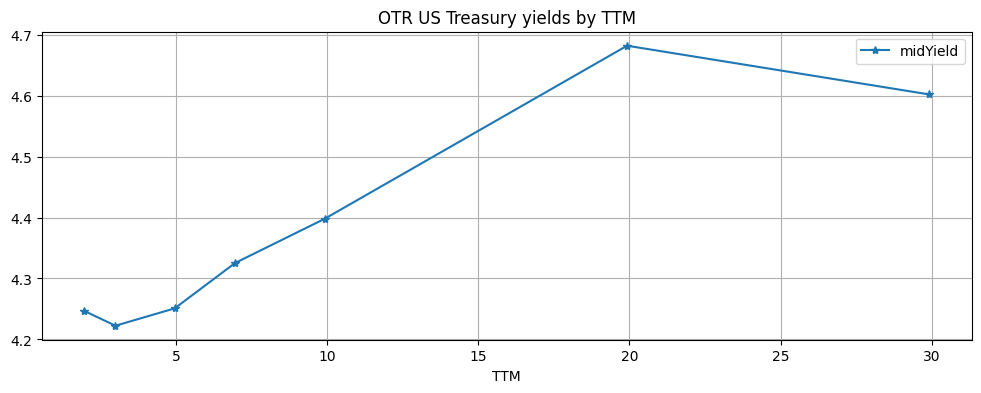

In [40]:
# Create symbology for on-the-run treasuries only
govt_symbology_otr = bond_symbology[bond_symbology['isin'].isin(govt_on_the_run_simple['isin'])].copy()
govt_symbology_otr = govt_symbology_otr.sort_values(by='TTM')

# Merge market data as of 2024-04-01 into treasury OTR symbology
govt_combined_otr = govt_symbology_otr.merge(bond_market_prices_eod,  on=['class','ticker','figi','isin'])

# Plot a graph/scatter plot of treasury OTR mid yields by TTM
govt_combined_otr.plot(x='TTM', y='midYield', grid=True, style='*-', title='OTR US Treasury yields by TTM', figsize=(12,4))

## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. 

Calibrate the bid, ask and mid discount factor curves as of 2024-12-13.

Display the calibration results for the mid curve, using get_yield_curve_details_df().

In [41]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    # yield_curve = ql.PiecewiseFlatForward(calc_date, bond_helpers, day_count)
    
    yield_curve.enableExtrapolation()
    return yield_curve



def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [42]:
# Calibrate the bid, ask and mid discount factor curves as of 2024-12-13.
tsy_yield_curve_bid = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'bidPrice')
tsy_yield_curve_mid = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'midPrice')
tsy_yield_curve_ask = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'askPrice')

# Display the calibration results for the mid curve
tsy_yield_curve_df = get_yield_curve_details_df(tsy_yield_curve_mid)
display(tsy_yield_curve_df)

ql_dates_yearly = [calc_date + ql.Period(y, ql.Years) for y in list(range(0, 30, 1))]
tsy_yield_curve_monthly_df = get_yield_curve_details_df(tsy_yield_curve_mid, curve_dates=ql_dates_yearly)
display(tsy_yield_curve_monthly_df)


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.127
1,2026-11-30,2.000,0.921,4.212
2,2027-12-15,3.000,0.882,4.279
3,2029-11-30,5.000,0.812,4.263
4,2031-11-30,7.000,0.742,4.357
5,2034-11-15,9.917,0.648,4.475
6,2044-11-15,19.917,0.390,4.839
7,2054-11-15,29.917,0.256,4.654


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.0,1.000,4.127
1,2025-12-13,1.0,0.960,4.148
2,2026-12-13,2.0,0.921,4.212
3,2027-12-13,3.0,0.882,4.279
4,2028-12-13,4.0,0.846,4.268
5,2029-12-13,5.0,0.812,4.263
6,2030-12-13,6.0,0.777,4.304
7,2031-12-13,7.0,0.742,4.357
8,2032-12-13,8.0,0.709,4.399
9,2033-12-13,9.0,0.677,4.437


## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

Text(0.5, 0, 'Date')

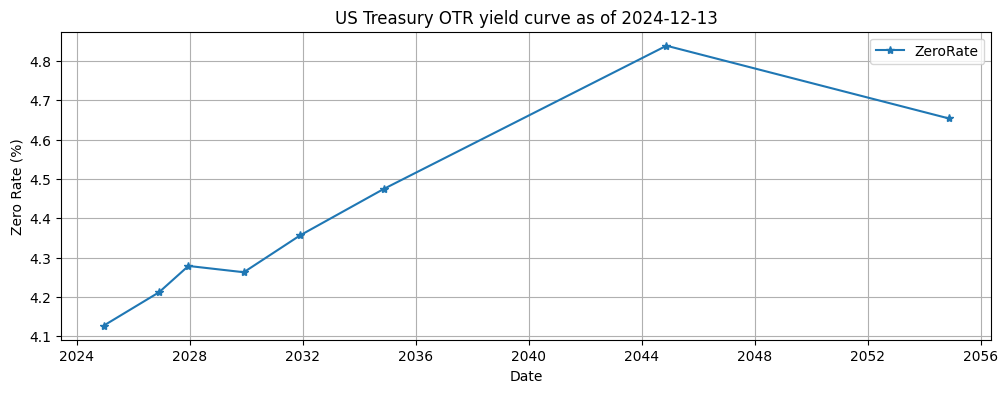

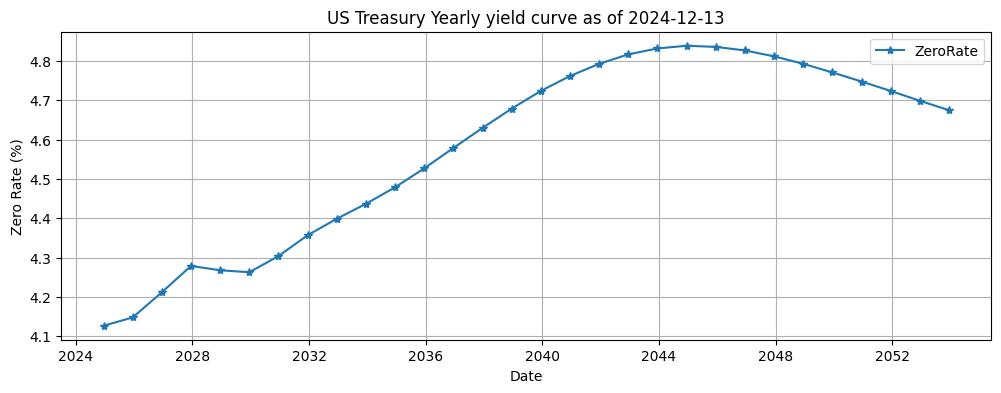

In [43]:
plt = tsy_yield_curve_df.plot(x='Date', y=['ZeroRate'], style='*-', grid=True, title=f'US Treasury OTR yield curve as of {as_of_date.date()}', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = tsy_yield_curve_monthly_df.plot(x='Date', y=['ZeroRate'], style='*-', grid=True, title=f'US Treasury Yearly yield curve as of {as_of_date.date()}', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')


## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

Text(0.5, 0, 'Date')

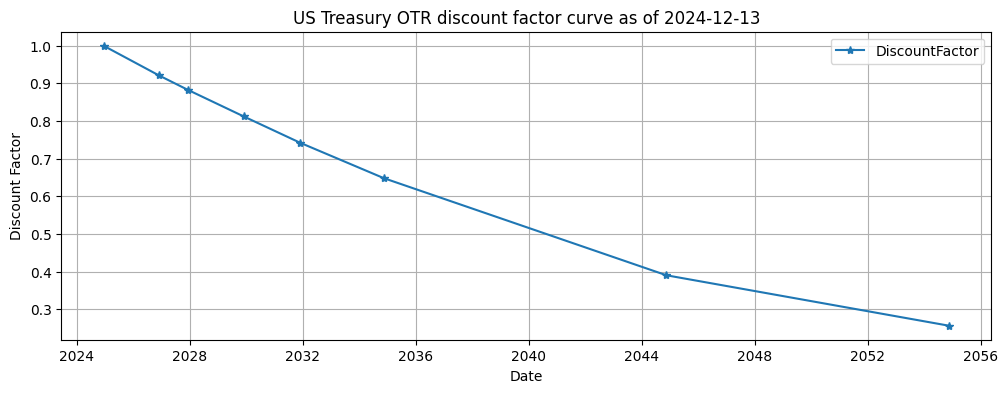

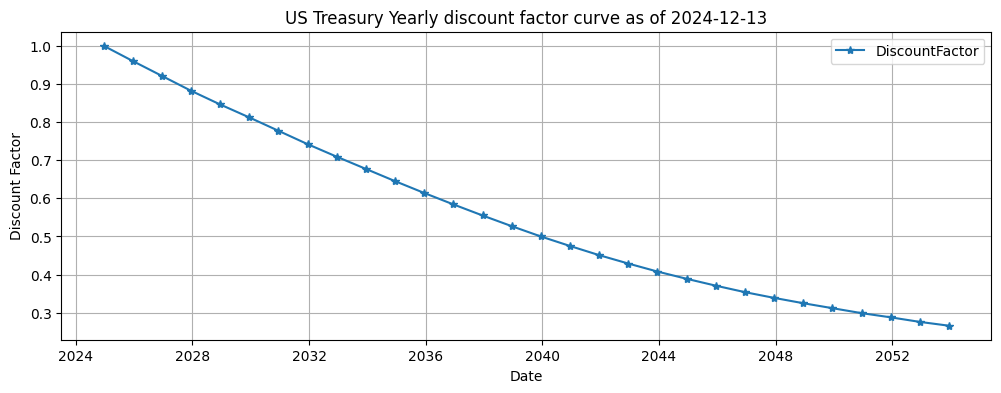

In [44]:
plt = tsy_yield_curve_df.plot(x='Date', y=['DiscountFactor'], style='*-', grid=True, title=f'US Treasury OTR discount factor curve as of {as_of_date.date()}', figsize=(12,4))
plt.set_ylabel('Discount Factor')
plt.set_xlabel('Date')

plt = tsy_yield_curve_monthly_df.plot(x='Date', y=['DiscountFactor'], style='*-', grid=True, title=f'US Treasury Yearly discount factor curve as of {as_of_date.date()}', figsize=(12,4))
plt.set_ylabel('Discount Factor')
plt.set_xlabel('Date')

------------------------------------------------------------------------------------------
# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Bond Present Value Calculation (no credit risk)" in the QuantLib Basic notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_mid)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid_price |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [45]:
# Create risk free bond_engine using calibrated US OTR yield curve
tsy_yield_curve_mid_handle = ql.YieldTermStructureHandle(tsy_yield_curve_mid)
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_mid_handle)

# Calculate mid prices
calculated_mid_prices = []
for index, row in govt_combined_otr.iterrows():
    bond_object = create_bond_from_symbology(row)
    bond_object.setPricingEngine(bond_engine)
    calculated_mid_prices.append(bond_object.cleanPrice())
    
govt_combined_otr['calc_mid_price'] = calculated_mid_prices
govt_combined_otr['calib_error'] = govt_combined_otr['midPrice'] - govt_combined_otr['calc_mid_price']

# Compare the calculated clean mid prices to the original market mid prices.
display(govt_combined_otr[['security', 'isin', 'figi', 'midPrice', 'calc_mid_price', 'calib_error']])

,security,isin,figi,midPrice,calc_mid_price,calib_error
0,T 4 1/4 11/30/26,US91282CLY56,BBG01QZFYJV6,100.00390,100.00390,-2.515321e-12
1,T 4 12/15/27,US91282CMB45,BBG01R4Z7Y32,99.37890,99.37890,-9.379164e-13
2,T 4 1/8 11/30/29,US91282CMA61,BBG01QZFYD58,99.44140,99.44140,-2.553691e-11
3,T 4 1/8 11/30/31,US91282CLZ22,BBG01QZFYCF9,98.80470,98.80470,1.305978e-11
4,T 4 1/4 11/15/34,US91282CLW90,BBG01QKHSMP5,98.82030,98.82030,-1.264766e-12
5,T 4 5/8 11/15/44,US912810UF39,BBG01QVTC1Y0,99.26565,99.26565,4.438050e-11
6,T 4 1/2 11/15/54,US912810UE63,BBG01QKHSL31,98.34375,98.34375,-7.915446e-12


## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


In [46]:
# Set yield conventions
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# Calculate dv01s, durations and convexities
dv01s = []
calc_durations = []
calc_convexities = []

for index, row in govt_combined_otr.iterrows():
    
    bond_object = create_bond_from_symbology(row)
    bond_object.setPricingEngine(bond_engine)
    
    settle_date = bond_object.settlementDate(calc_date)
    day_counter = bond_object.dayCounter()    
    
    bond_yield = bond_object.bondYield(row['calc_mid_price'], day_counter, compounding, coupon_freq, settle_date) * 100
    
    flat_int_rate = ql.InterestRate(bond_yield / 100, day_counter, compounding, coupon_freq)
    bond_duration = ql.BondFunctions.duration(bond_object, flat_int_rate)
    bond_convexity = ql.BondFunctions.convexity(bond_object, flat_int_rate)
    bond_dv01 = bond_object.dirtyPrice() * bond_duration / 100
    
    dv01s.append(bond_dv01)
    calc_durations.append(bond_duration)
    calc_convexities.append(bond_convexity)

# Add new risk columns and display results    
govt_combined_otr['dv01'] = dv01s
govt_combined_otr['duration'] = calc_durations
govt_combined_otr['convexity'] = calc_convexities

display(govt_combined_otr[['security', 'isin', 'figi', 'calc_mid_price', 'dv01', 'duration', 'convexity']])


,security,isin,figi,calc_mid_price,dv01,duration,convexity
0,T 4 1/4 11/30/26,US91282CLY56,BBG01QZFYJV6,100.00390,1.858630,1.855092,4.415198
1,T 4 12/15/27,US91282CMB45,BBG01R4Z7Y32,99.37890,2.777398,2.794447,9.412509
2,T 4 1/8 11/30/29,US91282CMA61,BBG01QZFYD58,99.44140,4.412681,4.429392,22.942988
3,T 4 1/8 11/30/31,US91282CLZ22,BBG01QZFYCF9,98.80470,5.910950,5.971500,41.654285
4,T 4 1/4 11/15/34,US91282CLW90,BBG01QKHSMP5,98.82030,7.910925,7.975989,75.888653
5,T 4 5/8 11/15/44,US912810UF39,BBG01QVTC1Y0,99.26565,12.799558,12.843004,218.619608
6,T 4 1/2 11/15/54,US912810UE63,BBG01QKHSL31,98.34375,15.966193,16.171718,377.782692


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib Basic notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [47]:
# Calculate scenario dv01s, durations and convexities
scen_dv01s = []
scen_durations = []
scen_convexities = []

for index, row in govt_combined_otr.iterrows():
    bond_object = create_bond_from_symbology(row)
    bond_object.setPricingEngine(bond_engine)
    
    # create interest rate scenarios
    interest_rate_bump = ql.SimpleQuote(0.0)
    calibrated_yield_curve_bumped = ql.ZeroSpreadedTermStructure(tsy_yield_curve_mid_handle, ql.QuoteHandle(interest_rate_bump))
    bond_engine_bumped = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(calibrated_yield_curve_bumped))
    bond_object.setPricingEngine(bond_engine_bumped)
    dirty_price_base = bond_object.dirtyPrice()
    
    # Create +1bp scenario
    interest_rate_bump.setValue(0.0001)
    dirty_price_plus = bond_object.dirtyPrice()    
    
    # Create -1bp scenario
    interest_rate_bump.setValue(-0.0001)
    dirty_price_minus = bond_object.dirtyPrice()
    
    # Calc scenario risks        
    scen_dv01 = (dirty_price_minus - dirty_price_base)*100
    scen_duration = scen_dv01  / dirty_price_base * 100
    scen_convexity = (dirty_price_plus + dirty_price_minus - 2 * dirty_price_base) / (dirty_price_base * 0.0001**2)
    
    scen_dv01s.append(scen_dv01)
    scen_durations.append(scen_duration)
    scen_convexities.append(scen_convexity)

# Add new scenario risk columns and display results
govt_combined_otr['scen_dv01'] = scen_dv01s
govt_combined_otr['scen_duration'] = scen_durations
govt_combined_otr['scen_convexity'] = scen_convexities

display(govt_combined_otr[['security', 'isin', 'figi','scen_dv01', 'scen_duration', 'scen_convexity']])


,security,isin,figi,scen_dv01,scen_duration,scen_convexity
0,T 4 1/4 11/30/26,US91282CLY56,BBG01QZFYJV6,1.934117,1.930435,3.794201
1,T 4 12/15/27,US91282CMB45,BBG01R4Z7Y32,2.830849,2.848227,8.355551
2,T 4 1/8 11/30/29,US91282CMA61,BBG01QZFYD58,4.543313,4.560519,21.992469
3,T 4 1/8 11/30/31,US91282CLZ22,BBG01QZFYCF9,6.075074,6.137305,40.850727
4,T 4 1/4 11/15/34,US91282CLW90,BBG01QKHSMP5,8.073794,8.140197,74.967174
5,T 4 5/8 11/15/44,US912810UF39,BBG01QVTC1Y0,12.996802,13.040917,219.430775
6,T 4 1/2 11/15/54,US912810UE63,BBG01QKHSL31,16.260505,16.469819,384.492934


------------------------------------------------------------------------------------------
# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the fixed-rate corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects.

Display the future cashflows for the `AAPL 2.2 09/11/29` bond.

In [48]:
# Create the fixed-rate corporate bond symbology + combined dataframes
corp_symbology = bond_symbology[bond_symbology['cpn_type'] == 'FIXED']
corp_combined = corp_symbology.merge(bond_market_prices_eod,  on=['class','ticker','figi','isin'])

display(corp_combined.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,term,TTM,date,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,30.0,18.39,2024-12-13,84.586,85.148,0.4490,5.157,5.105,84.8670,5.1310
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,30.0,19.39,2024-12-13,92.869,93.617,0.4940,5.030,4.966,93.2430,4.9980
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,30.0,20.16,2024-12-13,78.309,78.915,1.2170,5.200,5.143,78.6120,5.1715
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,30.0,20.41,2024-12-13,89.877,90.517,0.4010,5.184,5.130,90.1970,5.1570
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,10.0,1.20,2024-12-13,98.618,98.771,1.0205,4.455,4.321,98.6945,4.3880


In [49]:
# Create the corporate bond objects and store them in a dictionary
corp_bond_object_dict = {}

for index, row in corp_combined.iterrows():
    bond_details = row.to_dict()
    corp_bond_object = create_bond_from_symbology(bond_details)
    corp_bond_object_dict[row['security']] = corp_bond_object
    
# Display the future cashflows for the 'AAPL 2.2 09/11/29' bond.
corp_bond_key = 'AAPL 2.2 09/11/29'
corp_bond_cf = get_bond_cashflows(corp_bond_object_dict[corp_bond_key], calc_date=calc_date)

print("Corp bond future cashflows for", corp_bond_key)
display(corp_bond_cf)

Corp bond future cashflows for AAPL 2.2 09/11/29


,CashFlowDate,CashFlowYearFrac,CashFlowAmount
10,"March 11th, 2025",0.244444,1.1
11,"September 11th, 2025",0.744444,1.1
12,"March 11th, 2026",1.244444,1.1
13,"September 11th, 2026",1.744444,1.1
14,"March 11th, 2027",2.244444,1.1
15,"September 11th, 2027",2.744444,1.1
16,"March 11th, 2028",3.244444,1.1
17,"September 11th, 2028",3.744444,1.1
18,"March 11th, 2029",4.244444,1.1
19,"September 11th, 2029",4.744444,1.1


## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [50]:
# Create risk free bond engine
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_mid_handle)

# Set yield conventions
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# Calculate yields and zspreads
calc_yields = []
calc_zspreads = []

for index, row in corp_combined.iterrows():
        
    bond_object = create_bond_from_symbology(row)    
    bond_object.setPricingEngine(bond_engine)
    
    settle_date = bond_object.settlementDate(calc_date)
    day_counter = bond_object.dayCounter()

    clean_price = bond_object.cleanPrice()
    
    # yield in pct
    calc_yield = bond_object.bondYield(clean_price, day_counter, compounding, coupon_freq, settle_date) * 1e2
    flat_int_rate = ql.InterestRate(calc_yield / 100, day_counter, compounding, coupon_freq)
    bond_market_price = row['midPrice']
    
    # zspread in bps
    calc_zspread = ql.BondFunctions.zSpread(bond_object, bond_market_price, tsy_yield_curve_mid, day_counter, compounding, coupon_freq, settle_date) * 1e4
    
    calc_yields.append(calc_yield)
    calc_zspreads.append(calc_zspread)

# Add new columns and display results
corp_combined['calc_yield'] = calc_yields
corp_combined['calc_zspread'] = calc_zspreads

display(corp_combined[['security', 'isin', 'figi', 'midPrice', 'calc_yield', 'calc_zspread']])


,security,isin,figi,midPrice,calc_yield,calc_zspread
0,AAPL 3.85 05/04/43,US037833AL42,BBG004HST0K7,84.86700,4.690871,44.209729
1,AAPL 4.45 05/06/44,US037833AT77,BBG006F8VWJ7,93.24300,4.690436,30.926445
2,AAPL 3.45 02/09/45,US037833BA77,BBG0081TNL50,78.61200,4.705059,46.899239
3,AAPL 4 3/8 05/13/45,US037833BH21,BBG008N1BQC1,90.19700,4.688628,47.223583
4,AAPL 3 1/4 02/23/26,US037833BY53,BBG00C7QB7Q2,98.69450,4.014740,38.253085
...,...,...,...,...,...,...
410,T 4 1/4 11/30/26,US91282CLY56,BBG01QZFYJV6,100.00390,4.246940,0.000000
411,T 4 1/8 11/30/29,US91282CMA61,BBG01QZFYD58,99.44140,4.250797,0.000000
412,T 4 1/8 11/30/31,US91282CLZ22,BBG01QZFYCF9,98.80470,4.325524,0.000000
413,T 4 5/8 11/15/44,US912810UF39,BBG01QVTC1Y0,99.26565,4.681806,0.000000


## c. Validate Z-Spread computation for a few fixed rate corporate bonds

For the following corporate bonds:

* `IBM 1.95 05/15/30`
* `ORCL 2 7/8 03/25/31`
* `DIS 6.65 11/15/37`

use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)".

Validate/confirm that you match the original market prices, which were used as input to the z-Spread function.


In [51]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [52]:
# Create risk free bond engine
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_mid_handle)

# Set yield conventions
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# Select the 3 corporate bonds
selected_bonds = ['IBM 1.95 05/15/30', 'ORCL 2 7/8 03/25/31', 'DIS 6.65 11/15/37']
corp_combined_small = corp_combined[corp_combined['security'].isin(selected_bonds)].copy()

# Calculate prices with zspreads
bond_zspread_prices = []

for index, row in corp_combined_small.iterrows():
    
    bond_object = create_bond_from_symbology(row)    
    bond_object.setPricingEngine(bond_engine)
        
    bond_zspread_price = calc_clean_price_with_zspread(bond_object, tsy_yield_curve_mid_handle, row['calc_zspread']/1e4)
    bond_zspread_prices.append(bond_zspread_price)
    
# Validate that you match the original market prices, which were used as input to the z-Spread function.
corp_combined_small['bond_zspread_price'] = bond_zspread_prices
corp_combined_small['price_difference'] = corp_combined_small['midPrice'] - corp_combined_small['bond_zspread_price']

display(corp_combined_small[['security', 'isin', 'figi', 'calc_zspread', 'midPrice', 'bond_zspread_price','price_difference']])

,security,isin,figi,calc_zspread,midPrice,bond_zspread_price,price_difference
54,DIS 6.65 11/15/37,US254687EH59,BBG00QNKSBB5,71.402400,113.3845,113.3845,-1.312273e-09
85,IBM 1.95 05/15/30,US459200KJ94,BBG00TL9X0X0,60.203448,86.4350,86.4350,-1.719513e-12
120,ORCL 2 7/8 03/25/31,US68389XCE31,BBG00ZS0BP85,75.478036,88.7085,88.7085,5.080381e-11


## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|

Display the head of the dataframe.

Scatter plot duration and convexity by TTM for all AAPL (fixed-rate) bonds.

In [53]:
# Create risk free bond engine
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_mid_handle)

# Set yield conventions
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# Calculate durations and convexities
calc_durations = []
calc_convexities = []

for index, row in corp_combined.iterrows():
    
    bond_object = create_bond_from_symbology(row)
    bond_object.setPricingEngine(bond_engine)
    
    settle_date = bond_object.settlementDate(calc_date)
    day_counter = bond_object.dayCounter()    
    
    bond_yield = bond_object.bondYield(row['midPrice'], day_counter, compounding, coupon_freq, settle_date) * 100
    
    flat_int_rate = ql.InterestRate(bond_yield / 100, day_counter, compounding, coupon_freq)
    bond_duration = ql.BondFunctions.duration(bond_object, flat_int_rate)
    bond_convexity = ql.BondFunctions.convexity(bond_object, flat_int_rate)        
    
    calc_durations.append(bond_duration)
    calc_convexities.append(bond_convexity)

# Add new risk columns and display results
corp_combined['calc_duration'] = calc_durations
corp_combined['calc_convexity'] = calc_convexities

display(corp_combined[['security', 'isin', 'figi', 'midPrice', 'calc_duration', 'calc_convexity']].head())


,security,isin,figi,midPrice,calc_duration,calc_convexity
0,AAPL 3.85 05/04/43,US037833AL42,BBG004HST0K7,84.8670,12.454454,200.814070
1,AAPL 4.45 05/06/44,US037833AT77,BBG006F8VWJ7,93.2430,12.557914,208.879027
2,AAPL 3.45 02/09/45,US037833BA77,BBG0081TNL50,78.6120,13.312465,233.578240
3,AAPL 4 3/8 05/13/45,US037833BH21,BBG008N1BQC1,90.1970,12.913241,223.492315
4,AAPL 3 1/4 02/23/26,US037833BY53,BBG00C7QB7Q2,98.6945,1.137089,1.868020


Text(0, 0.5, 'Convexity')

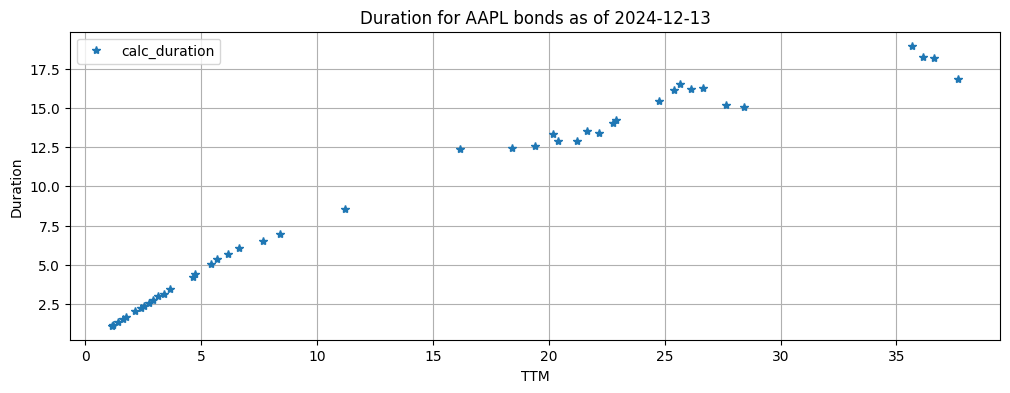

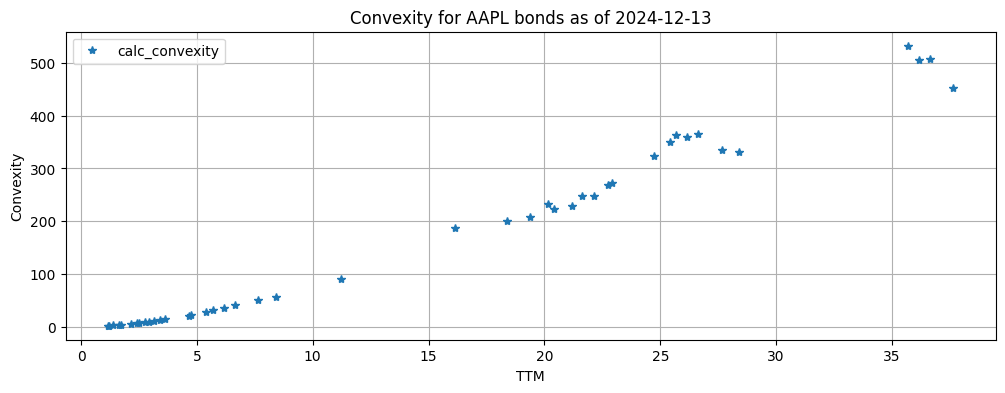

In [63]:
# Scatter plot duration and convexity by TTM for all AAPL (fixed-rate) bonds.
corp_combined_aapl = corp_combined[corp_combined['ticker'] == 'AAPL']

plt = corp_combined_aapl.plot(x='TTM', y=['calc_duration'], style='*', grid=True, title=f'Duration for AAPL bonds as of {as_of_date.date()}', figsize=(12,4))
plt.set_ylabel('Duration')


plt = corp_combined_aapl.plot(x='TTM', y=['calc_convexity'], style='*', grid=True, title=f'Convexity for AAPL bonds as of {as_of_date.date()}', figsize=(12,4))
plt.set_ylabel('Convexity')

